In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import seaborn as sn
import pandas as pd
import torchnet.meter.confusionmeter as cm
import random

c:\Users\Yilun\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import PIL
from PIL import Image
import skimage
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

In [3]:
def augmenttest():
        path_img = 'marvel/train/hulk/pic_001.jpg'
        img = skimage.io.imread(path_img)
        img_pil = Image.fromarray(np.asarray(img))
        #augm = transforms.RandomRotation(degrees=(-20,20))
        augm = transforms.Compose([transforms.RandomApply(transforms=nn.ModuleList([transforms.RandomRotation(degrees=(-20,20))]), p=0.3),
                transforms.RandomApply(transforms=nn.ModuleList([transforms.RandomResizedCrop(224)]), p=0.3),
                transforms.RandomApply(transforms=nn.ModuleList([transforms.RandomHorizontalFlip()]), p=0.3),
                transforms.CenterCrop(224),])
        img_auged = augm(img_pil)

        fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,4), sharex = True, sharey = True)

        ax1.axis('off')
        ax1.imshow(img_pil)
        ax1.set_title('Input')

        ax2.axis('off')
        ax2.imshow(np.array(img_auged), cmap=plt.cm.gray)
        ax2.set_title('Histogram of Oriented Gradients')
        plt.show()

        print(img.shape)
        #print(img_auged.size)

In [4]:

# Data augmentation and normalization for training
# Just normalization for validation & test

data_transforms = {
    'train': transforms.Compose([
        transforms.RandAugment(),
        # apply limited data augmentation methods randomly
        #transforms.RandomApply(transforms=nn.ModuleList([transforms.RandomRotation(degrees=(-10,10))]), p=0.3),
        #transforms.RandomApply(transforms=nn.ModuleList([transforms.RandomResizedCrop(224)]), p=0.3),
        #transforms.RandomApply(transforms=nn.ModuleList([transforms.RandomHorizontalFlip()]), p=0.3),
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# define basic variables

data_dir = 'marvel'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}

kf = KFold(n_splits=3, shuffle=True, random_state=114514)

batch_size = 16

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
#Train the model

def train_model(model, criterion, optimizer, scheduler, num_epochs, dataloaders, dataset_sizes):
    epoch_counter_train = []
    epoch_counter_val = []
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    since = time.time()
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch +1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                #scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double().cpu() / dataset_sizes[phase]

            #For graph generation
            if phase == "train":
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
                epoch_counter_train.append(epoch)
            if phase == "valid":
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)
                epoch_counter_val.append(epoch)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the best model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)

    # final validation for each class
    phase = 'valid'
    model.eval()   # Set model to evaluate mode
    running_loss = 0.0
    running_corrects = 0
    
    y_true = []
    y_pre = []
    for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # track history if only in train
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            loss = criterion(outputs, labels)
            y_true.extend(labels.to('cpu'))
            y_pre.extend(preds.to('cpu'))
        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    print(classification_report(y_true,y_pre))

    #for printing        
    epoch_loss = running_loss / dataset_sizes[phase]
    epoch_acc = running_corrects.double().cpu() / dataset_sizes[phase]
    
    print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        phase, epoch_loss, epoch_acc))
    print()

    # load best model weights
    model.load_state_dict(best_model_wts)
    return best_model_wts, epoch_loss, epoch_acc


In [6]:
# Using k-fold cross validation
best_model_wts = None
min_loss = 999
min_acc = -999
for i, (train_index, val_index) in enumerate(kf.split(image_datasets['train'])):
    #Using a model pre-trained on ImageNet and replacing it's final linear layer
    #For resnet18 or resnet50
    model_ft = models.resnet18(pretrained=True)
    num_ftrs = model_ft.fc.in_features
    print(num_ftrs)
    model_ft.fc = nn.Sequential(
        #nn.Flatten(),
        nn.Linear(num_ftrs, 64),
        #nn.Sigmoid(),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(64, 8),
        )
    model_ft = model_ft.to(device)

    # Using label smoothing for false labeled input data
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    # Using Adam as the parameter optimizer
    optimizer_ft = optim.Adam(model_ft.parameters(), lr = 0.001, betas=(0.9, 0.999))

    # Decay Learning rate by a factor of 0.1 every 10 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)      


    train = torch.utils.data.Subset(image_datasets['train'], train_index)
    val = torch.utils.data.Subset(image_datasets['train'], val_index)

    trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=4)
    valloader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=True, num_workers=4)

    # load images in 'valid' folder as test data
    testloader = torch.utils.data.DataLoader(image_datasets['valid'], batch_size=batch_size,
                                                shuffle=True, num_workers=4)

    dataloaders = {'train': trainloader, 'valid': valloader, 'test': testloader}
                                                
    dataset_sizes = {'train': len(dataloaders['train'].dataset.dataset),
                    'valid': len(dataloaders['valid'].dataset.dataset),
                    'test': len(dataloaders['test'].dataset)}
                    
    #lists for graph generation
    epoch_counter_train = []
    epoch_counter_val = []
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []

    wts, loss, acc = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50, dataloaders = dataloaders, dataset_sizes = dataset_sizes)
    if (acc > min_acc):
        best_model_wts = copy.deepcopy(wts)
    


c:\Users\Yilun\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\Yilun\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


512
Epoch 1/50
----------
train Loss: 1.3317 Acc: 0.1563
valid Loss: 0.6482 Acc: 0.0820

Epoch 2/50
----------
train Loss: 1.2883 Acc: 0.1927
valid Loss: 0.6817 Acc: 0.0724

Epoch 3/50
----------
train Loss: 1.2511 Acc: 0.2132
valid Loss: 0.6344 Acc: 0.1142

Epoch 4/50
----------
train Loss: 1.2120 Acc: 0.2217
valid Loss: 0.6623 Acc: 0.1041

Epoch 5/50
----------
train Loss: 1.1967 Acc: 0.2461
valid Loss: 0.5875 Acc: 0.1335

Epoch 6/50
----------
train Loss: 1.1469 Acc: 0.2794
valid Loss: 1.0020 Acc: 0.0933

Epoch 7/50
----------
train Loss: 1.1288 Acc: 0.2949
valid Loss: 0.6563 Acc: 0.1235

Epoch 8/50
----------
train Loss: 1.0910 Acc: 0.3115
valid Loss: 0.5935 Acc: 0.1254

Epoch 9/50
----------
train Loss: 1.0732 Acc: 0.3278
valid Loss: 0.5459 Acc: 0.1641

Epoch 10/50
----------
train Loss: 1.0639 Acc: 0.3239
valid Loss: 0.6812 Acc: 0.1254

Epoch 11/50
----------
train Loss: 0.9591 Acc: 0.3951
valid Loss: 0.5117 Acc: 0.1757

Epoch 12/50
----------
train Loss: 0.8858 Acc: 0.4203
valid

c:\Users\Yilun\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\Yilun\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


train Loss: 1.3330 Acc: 0.1691
valid Loss: 0.6604 Acc: 0.0890

Epoch 2/50
----------
train Loss: 1.2598 Acc: 0.2136
valid Loss: 0.7424 Acc: 0.1091

Epoch 3/50
----------
train Loss: 1.2144 Acc: 0.2446
valid Loss: 0.7578 Acc: 0.0844

Epoch 4/50
----------
train Loss: 1.1710 Acc: 0.2767
valid Loss: 0.5832 Acc: 0.1354

Epoch 5/50
----------
train Loss: 1.1265 Acc: 0.2953
valid Loss: 0.5756 Acc: 0.1382

Epoch 6/50
----------
train Loss: 1.0654 Acc: 0.3293
valid Loss: 0.5750 Acc: 0.1494

Epoch 7/50
----------
train Loss: 1.0642 Acc: 0.3286
valid Loss: 0.5602 Acc: 0.1428

Epoch 8/50
----------
train Loss: 1.0104 Acc: 0.3692
valid Loss: 0.5628 Acc: 0.1455

Epoch 9/50
----------
train Loss: 0.9822 Acc: 0.3769
valid Loss: 0.5375 Acc: 0.1664

Epoch 10/50
----------
train Loss: 0.9468 Acc: 0.3909
valid Loss: 0.5306 Acc: 0.1602

Epoch 11/50
----------
train Loss: 0.8216 Acc: 0.4466
valid Loss: 0.4736 Acc: 0.1958

Epoch 12/50
----------
train Loss: 0.7762 Acc: 0.4710
valid Loss: 0.4724 Acc: 0.1974


c:\Users\Yilun\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\Yilun\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


train Loss: 1.3164 Acc: 0.1807
valid Loss: 0.6924 Acc: 0.0584

Epoch 2/50
----------
train Loss: 1.2766 Acc: 0.1989
valid Loss: 0.6343 Acc: 0.1076

Epoch 3/50
----------
train Loss: 1.2078 Acc: 0.2527
valid Loss: 0.8953 Acc: 0.0925

Epoch 4/50
----------
train Loss: 1.1466 Acc: 0.2906
valid Loss: 0.6807 Acc: 0.1169

Epoch 5/50
----------
train Loss: 1.1467 Acc: 0.2794
valid Loss: 0.6628 Acc: 0.1149

Epoch 6/50
----------
train Loss: 1.0671 Acc: 0.3185
valid Loss: 0.6207 Acc: 0.1235

Epoch 7/50
----------
train Loss: 1.0515 Acc: 0.3448
valid Loss: 0.6528 Acc: 0.1277

Epoch 8/50
----------
train Loss: 0.9990 Acc: 0.3746
valid Loss: 0.5853 Acc: 0.1699

Epoch 9/50
----------
train Loss: 0.9689 Acc: 0.3847
valid Loss: 0.5231 Acc: 0.1730

Epoch 10/50
----------
train Loss: 0.9569 Acc: 0.3870
valid Loss: 0.5248 Acc: 0.1660

Epoch 11/50
----------
train Loss: 0.8440 Acc: 0.4400
valid Loss: 0.4841 Acc: 0.1865

Epoch 12/50
----------
train Loss: 0.7777 Acc: 0.4795
valid Loss: 0.4667 Acc: 0.1981


In [7]:

def plot_result():#Plot the train & validation losses
    plt.figure(1)
    plt.title("Training Vs Validation Losses")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(epoch_counter_train,train_loss,color = 'r', label="Training Loss")
    plt.plot(epoch_counter_val,val_loss,color = 'g', label="Validation Loss")
    plt.legend()
    plt.savefig('loss_smooth8.jpg')
    plt.show()

    #Plot the accuracies in train & validation
    plt.figure(2)
    plt.title("Training Vs Validation Accuracies")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(epoch_counter_train,train_acc,color = 'r', label="Training Accuracy")
    plt.plot(epoch_counter_val,val_acc,color = 'g', label="Validation Accuracy")
    plt.legend()
    plt.savefig('acc_smooth8.jpg')
    plt.show()

c:\Users\Yilun\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\Yilun\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Accuracy of the network on the test images: 59 %
Accuracy of black widow : 54 %
Accuracy of captain america : 45 %
Accuracy of doctor strange : 62 %
Accuracy of  hulk : 69 %
Accuracy of ironman : 58 %
Accuracy of  loki : 53 %
Accuracy of spider-man : 68 %
Accuracy of thanos : 60 %
[[29  9  6  4  3  2  1  1]
 [ 6 26  5  2  5  4  4  5]
 [ 5  4 36  2  5  2  3  4]
 [ 2  1  1 38  7  1  2  4]
 [ 2  6  3  3 33  3  4  2]
 [ 4  6  6  3  0 27  1  7]
 [ 1  4  5  1  4  0 40  2]
 [ 3  3  1  3  4  4  1 36]]


<AxesSubplot:>

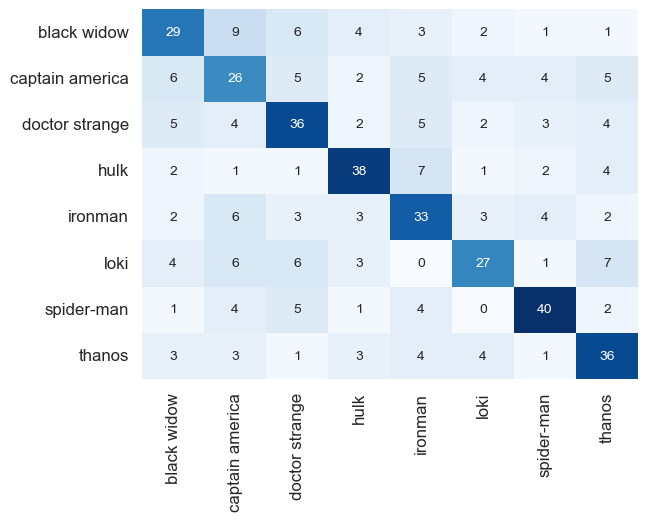

In [8]:

#Test the accuracy with test data

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Sequential(
    #nn.Flatten(),
    nn.Linear(num_ftrs, 64),
    #nn.Sigmoid(),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(64, 8),
    )
model_ft = model_ft.to(device)
model_ft.load_state_dict(best_model_wts)

correct = 0
total = 0
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_ft(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

#Class wise testing accuracy
class_correct = list(0. for i in range(8))
class_total = list(0. for i in range(8))
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_ft(inputs)
            _, predicted = torch.max(outputs, 1)
            point = (predicted == labels).squeeze()
            for j in range(len(labels)):
                label = labels[j]
                class_correct[label] += point[j].item()
                class_total[label] += 1

for i in range(8):
    print('Accuracy of %5s : %2d %%' % (
        class_names[i], 100 * class_correct[i] / class_total[i]))


#Get the confusion matrix for testing data
confusion_matrix = cm.ConfusionMeter(8)
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test']):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_ft(inputs)
        _, predicted = torch.max(outputs, 1)
        confusion_matrix.add(predicted, labels)
    print(confusion_matrix.conf)

#Confusion matrix as a heatmap
con_m = confusion_matrix.conf
df_con_m = pd.DataFrame(con_m, index= [i for i in class_names], columns = [i for i in class_names])
sn.set(font_scale= 1.1)
sn.heatmap(df_con_m, annot=True,fmt='g' ,  annot_kws={"size" : 10}, cbar = False, cmap="Blues") 